# EDA

### Installing requirements

This notebook requires theese modules to be installed:
- pandas
- matplotlb

In [2]:
%pip install pandas matplotlib


[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Initializing modules and data

In [3]:
import pandas as pd
import datetime as dt

mw = pd.read_csv("message-weather.csv")

### Normalize column names

In [4]:
mw.date_weather = mw.date_weather.apply(lambda date: dt.datetime.strptime(date, "%Y-%m-%d %H:%M"))
mw.date_hour_x = mw.date_hour_x.apply(lambda date: dt.datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))
mw = mw.rename(columns = {
    "tg_message": "message_text",
    "date_hour_x": "weather_time",
    "date_weather": "message_time",
    "latitude_decimal": "latitude",
    "longitude_decimal": "longitude",
    "region_x": "region",
})

mw.head(5)

,city,message_time,latitude,longitude,max_temperature,min_temperature,region,temperature,wind_direction,wind_speed,weather_description,weather_time,message_text
0,Суми,2022-12-02 12:32:00,50.911944,34.803333,-0.2,-3.3,Сумська,-0.2,343,31.2,Overcast,2022-12-02 12:00:00,💥 Хотінь (Сумська обл.)\nЗагроза артилерійсько...
1,Марганець,2022-12-02 11:33:00,47.644722,34.604167,2.7,-0.1,Дніпропетровська,2.7,3,28.5,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
2,Дніпро,2022-12-02 11:33:00,48.466111,35.025278,1.7,-1.6,Дніпропетровська,1.7,357,29.9,Partly cloudy,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
3,Нікополь,2022-12-02 11:33:00,47.577222,34.357500,2.4,0.1,Дніпропетровська,2.4,7,25.4,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
4,Дніпро,2022-12-02 11:33:00,48.466111,35.025278,1.7,-1.6,Дніпропетровська,1.7,357,29.9,Partly cloudy,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...


## Analysing

### Temperature at Dnipro

<Axes: xlabel='message_time'>

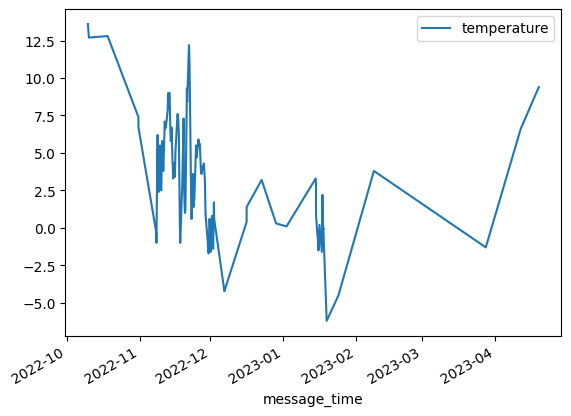

In [5]:
(mw.loc[mw.city == "Дніпро"]
  .sort_values(by="message_time")
  .plot.line("message_time", "temperature"))

### Weather in Ukraine

In [6]:
mw.groupby([mw.city, mw.weather_description]).size().sort_values()

city              weather_description
Івано-Франківськ  Snow fall: Slight        1
                  Mainly clear             1
Іскрисківщина     Snow fall: Slight        1
Шалигине          Clear sky                1
Чорнобаївка       Partly cloudy            1
                                        ... 
Херсон            Overcast               109
Харків            Partly cloudy          125
Дніпро            Drizzle: Light         178
                  Overcast               182
Харків            Overcast               219
Length: 1105, dtype: int64

<Axes: xlabel='weather_description'>

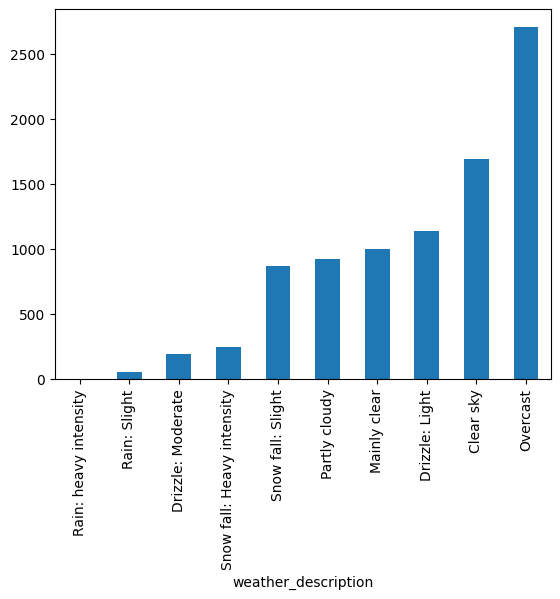

In [7]:
data = mw.groupby([mw.city, mw.weather_description]).size()
data.reset_index().groupby("weather_description")[0].sum().sort_values().plot.bar()